In [1]:
import torch
from utils import load_ckpt, visualize_depth
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np
import os
from tqdm import tqdm
import imageio
import random

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [2]:
# Change to your settings...
############################
N_vocab = 1500
encode_appearance = True
N_a = 48
encode_transient = True
N_tau = 16
beta_min = 0.1 # doesn't have effect in testing
ckpt_path = "/home/laylay/nerf_pl/ckpts/ckpt_scale2with4layers/epoch=19.ckpt"

N_emb_xyz = 15
N_emb_dir = 4
N_samples = 256
N_importance = 256
use_disp = False
# chunk = 1024*32
chunk = 16384
#############################

embedding_xyz = PosEmbedding(N_emb_xyz-1, N_emb_xyz)
embedding_dir = PosEmbedding(N_emb_dir-1, N_emb_dir)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(N_vocab, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
if encode_transient:
    embedding_t = torch.nn.Embedding(N_vocab, N_tau).cuda()
    load_ckpt(embedding_t, ckpt_path, model_name='embedding_t')
    embeddings['t'] = embedding_t
    

nerf_coarse = NeRF('coarse',
                   in_channels_xyz=6*N_emb_xyz+3,
                   in_channels_dir=6*N_emb_dir+3).cuda()
nerf_fine = NeRF('fine',
                 in_channels_xyz=6*N_emb_xyz+3,
                 in_channels_dir=6*N_emb_dir+3,
                 encode_appearance=encode_appearance,
                 in_channels_a=N_a,
                 encode_transient=encode_transient,
                 in_channels_t=N_tau,
                 beta_min=beta_min).cuda()

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

models = {'coarse': nerf_coarse, 'fine': nerf_fine}

In [3]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        if 'a_embedded' in kwargs:
            kwargs_['a_embedded'] = kwargs['a_embedded'][i:i+chunk]
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [4]:
def generate_pose(alpha=0, beta=np.pi, gamma=np.pi, x=0, y=0, z=0):
    # alpha for up down
    # beta for left right
    # gamma for whole picture rotation
    p = np.array([[np.cos(gamma)*np.cos(beta), -np.sin(gamma)*np.cos(alpha)+np.cos(gamma)*np.sin(beta)*np.sin(alpha), np.sin(gamma)*np.sin(alpha)+np.cos(gamma)*np.sin(beta)*np.cos(alpha), x],
                [np.sin(gamma)*np.cos(beta), np.cos(gamma)*np.cos(alpha)+np.sin(gamma)*np.sin(beta)*np.sin(alpha), -np.cos(gamma)*np.sin(alpha)+np.sin(gamma)*np.sin(beta)*np.cos(alpha), y],
                [-np.sin(beta), np.cos(beta)*np.sin(alpha), np.cos(beta)*np.cos(alpha), z]])
    return p

In [5]:
dataset = dataset_dict["phototourism"] \
            ("/home/laylay/nerf_pl/Data/StitchingData/brandenburg_gate", 
             split="test", 
             img_downscale=2, use_cache=True)

In [6]:
# beta +0.3~-0.3
# alpha +0.1~-0.1
al = 0.1
be = np.pi+0.3
input1 = []
input2 = []
for i in range(5):
    input1 += [generate_pose(alpha=0, beta=np.pi+0.3-i*0.1)]
    input2 += [generate_pose(alpha=random.randint(-1, 1) / 10, beta=np.pi+0.2-0.1*i)]

input1 = np.array(input1)
input2 = np.array(input2)
input_merge = (input1 + input2) / 2

In [8]:
dataset.poses_test = input_merge
h, w = 400, 600
dataset.test_img_w, dataset.test_img_h = w, h
dataset.test_focal = dataset.test_img_w * 1.5 / np.tan(np.pi / 6)
dataset.test_K = np.array([[dataset.test_focal, 0, dataset.test_img_w/2],
                           [0, dataset.test_focal, dataset.test_img_h/2],
                           [0,                   0,                  1]])
dataset.test_appearance_idx = 1123

img_pred = []
for i in range(len(dataset)):
    sample = dataset[i]
    rays = sample["rays"].cuda()
    ts = sample["ts"].cuda()
    result = f(rays, ts)
    img_wh = tuple(sample["img_wh"].numpy())
    img_pred += [result["rgb_fine"].view(img_wh[1], img_wh[0], 3).cpu().numpy()]
    imageio.imwrite(os.path.join("/home/laylay/UDIS2/Data/try/Synthesis_input", f'{i:03d}.jpg'), img_pred[i])
# plt.subplots(figsize=(15, 8))
# plt.tight_layout()
# for i in range(len(dataset)):
#     plt.subplot(int(str(1)+str(len(dataset))+str(i+1)))
#     plt.imshow(img_pred[i])
#     plt.axis("off")
# plt.show()

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
dataset = dataset_dict["phototourism"] \
            ("/home/laylay/nerf_pl/Data/brandenburg_5View", 
             split="test", 
             img_downscale=2, use_cache=True)

dataset.poses_test = dataset.poses
h, w = 400, 600

dataset.test_img_w, dataset.test_img_h = w, h
dataset.test_focal = dataset.test_img_w/2/np.tan(np.pi/6) # fov=60 degrees
dataset.test_K = np.array([[dataset.test_focal, 0, dataset.test_img_w/2],
                            [0, dataset.test_focal, dataset.test_img_h/2],
                            [0,                  0,                    1]])
key = np.array(list(dataset.poses_dict.keys()))
all_image_pred = []
n = len(dataset)
for i in range(n):
    dataset.test_appearance_idx = key[0]
    sample = dataset[i]
    rays = sample["rays"].cuda()
    ts = sample["ts"].cuda()
    results = f(rays, ts)
    img_wh = tuple(sample['img_wh'].numpy())
    img_pred = results["rgb_fine"].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    all_image_pred += [img_pred]

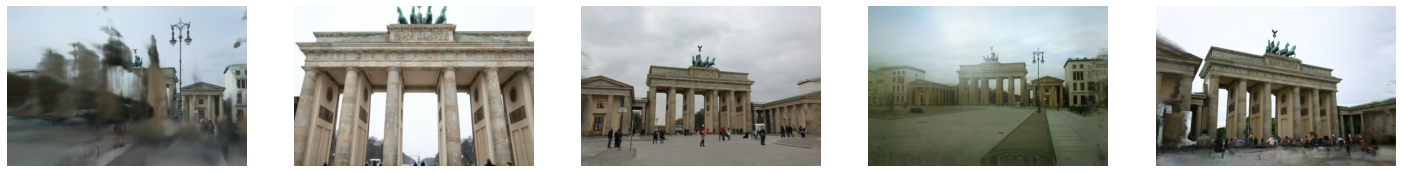

In [7]:
plt.subplots(figsize=(20, 10))
plt.tight_layout()
for i in range(n):
    plt.subplot(int(str(1)+str(n)+str(i+1)))
    plt.imshow(all_image_pred[i])
    plt.axis("off")
plt.show()

In [ ]:
dataset = dataset_dict["phototourism"] \
            ("/home/laylay/nerf_pl/Data/StitchingData/brandenburg_gate", 
             split="test", 
             img_downscale=2, use_cache=True)
dataset.poses_test = np.tile(p, (120, 1, 1))
diff = np.linspace(0, 0.6, 120)
for i in range(120):
    dataset.poses_test[i, 0, 3] += diff[i]
N_frames = 120
imgs = []
depth = []
h, w = 400, 600
dataset.test_img_w, dataset.test_img_h = w, h
dataset.test_focal = dataset.test_img_w/2/np.tan(np.pi/6) # fov=60 degrees
dataset.test_K = np.array([[dataset.test_focal, 0, dataset.test_img_w/2],
                            [0, dataset.test_focal, dataset.test_img_h/2],
                            [0,                  0,                    1]])

dataset.test_appearance_idx = 1123

os.makedirs("results/phototourism/brandenburg_gate_scale2/0", exist_ok=True)
for i in tqdm(range(N_frames)):
    sample = dataset[i]
    rays = sample["rays"].cuda()
    ts = sample["ts"].cuda()
    results = f(rays, ts)
    img_pred = np.clip(results['rgb_fine'].view(h, w, 3).cpu().numpy(), 0, 1)
    depth_pred = results['depth_fine'].view(h, w)
    img_pred_ = (img_pred*255).astype(np.uint8)
    depth += [visualize_depth(depth_pred).permute(1, 2, 0)]
    imgs += [img_pred_]
    imageio.imwrite(os.path.join("results/phototourism/brandenburg_gate_scale2/0", f'{i:03d}.png'), img_pred_)
imageio.mimsave(os.path.join("results/phototourism/brandenburg_gate_scale2/0", "video.gif"),
                        imgs, fps=60)
imageio.mimsave(os.path.join("results/phototourism/brandenburg_gate_scale2/0", "depth.gif"), depth, fps=60)

In [7]:
for i in range(len(dataset)):
    imageio.imwrite(os.path.join("/home/laylay/UDIS2/Data/NeRF_W/try/input1", f'{i:03d}.jpg'), img_pred[i])

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
